In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested
from phe import *
from phe import map_data as phe_map_data
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

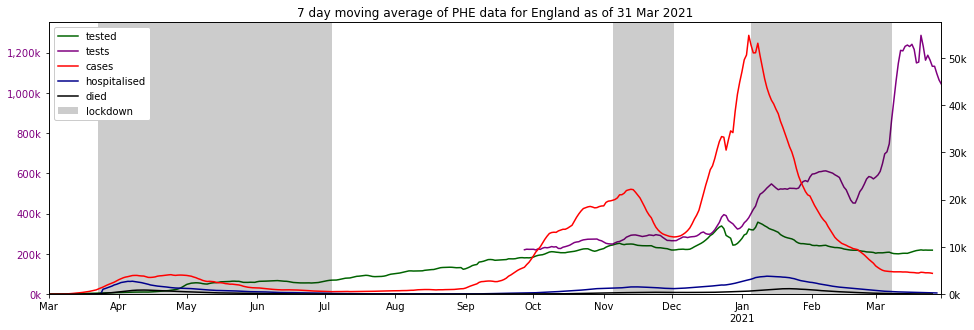

In [2]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

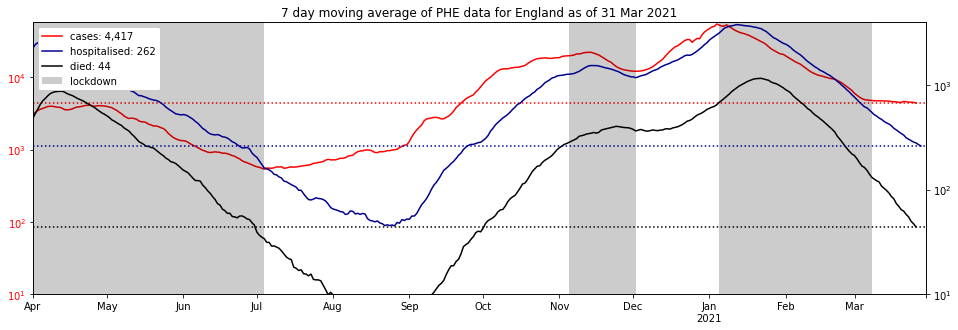

In [3]:
plot_summary(earliest_date='2020-04-01', show_latest='lines', log=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

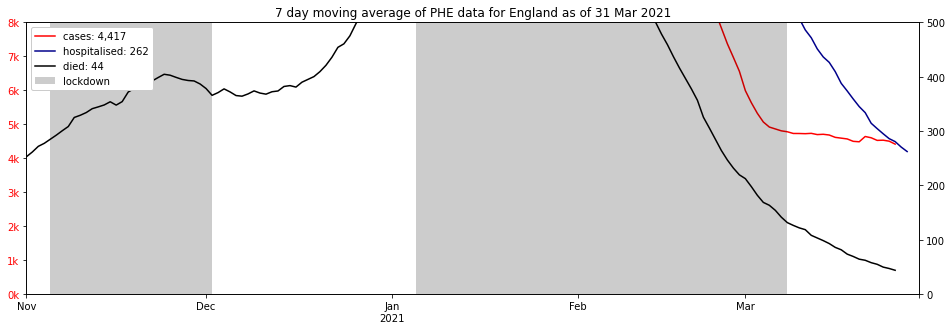

In [4]:
plot_summary(earliest_date='2020-11-01', show_latest=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter, left_ymax=8_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=500)

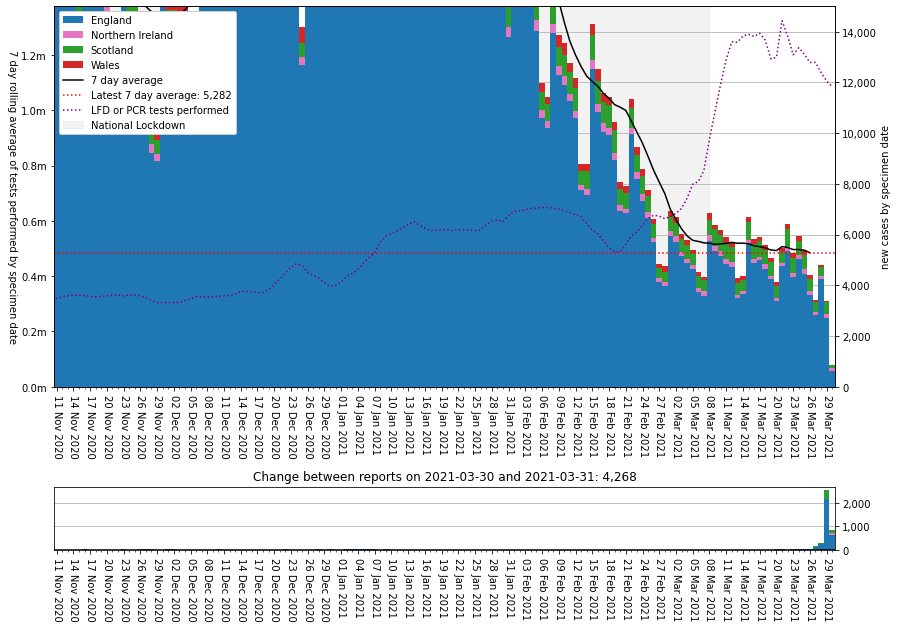

In [5]:
plot_areas(for_date, 'cases_nations', ylim=15_000, earliest='2020-11-11')

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,3177357.0,26266174.0,23088817.0,56286961,5.644925,41.019832,53.335242
1,Northern Ireland,N92000002,138486.0,749112.0,610626.0,1893667,7.313113,32.245691,60.441197
2,Scotland,S92000003,354756.0,2463069.0,2108313.0,5463300,6.493438,38.590467,54.916095
3,Wales,W92000004,437937.0,1427183.0,989246.0,3152879,13.890067,31.375958,54.733975


'partial: 30,905,538 (46.3%), full: 4,108,536'

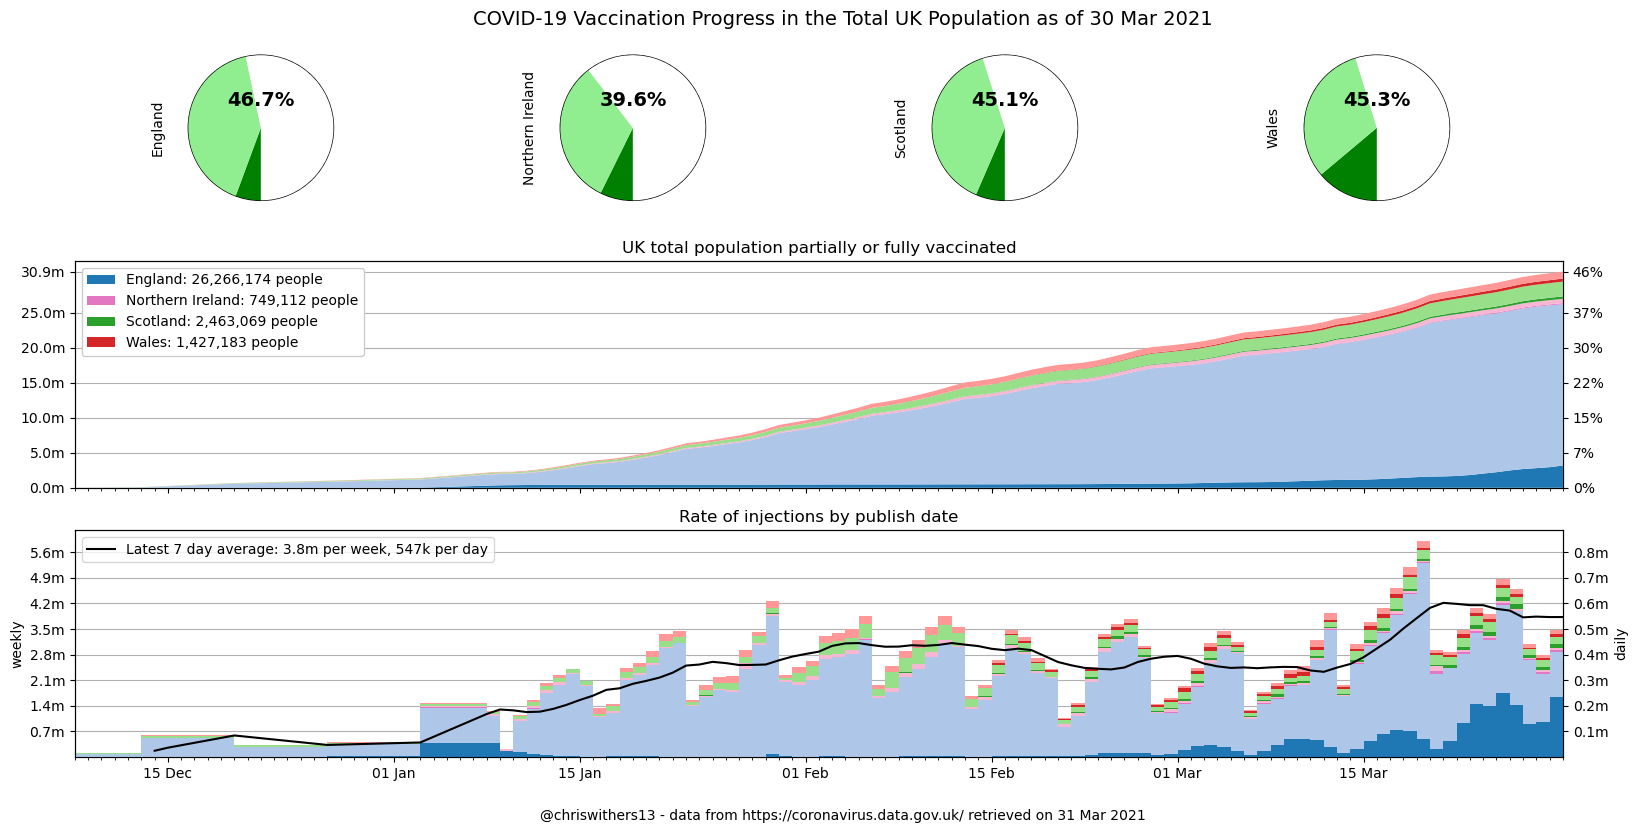

In [6]:
results = vaccination_dashboard(show_partial=True)
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

In [7]:
vaccination_changes()

,,First Dose (New),Second Dose (New),Complete (New),First Dose (Total),Second Dose (Total),Complete (Total)
,,,,,,,
England,30 Mar 21,"+176,063","+233,828","+233,828","+26,266,174","+3,177,357","+3,177,357"
Northern Ireland,30 Mar 21,"+8,383","+6,464","+6,464","+749,112","+138,486","+138,486"
Scotland,30 Mar 21,"+26,671","+16,313","+16,313","+2,463,069","+354,756","+354,756"
Wales,30 Mar 21,"+13,473","+13,921","+13,921","+1,427,183","+437,937","+437,937"


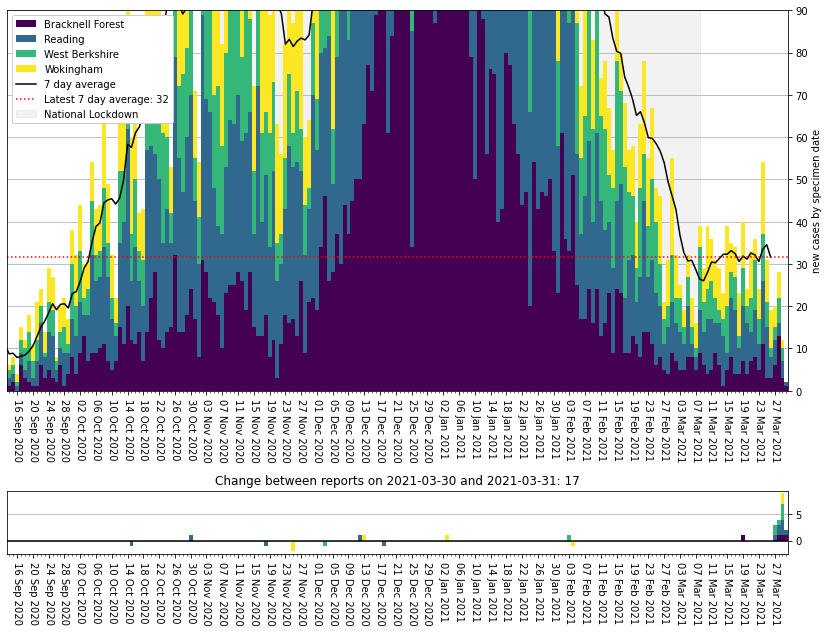

In [8]:
plot_areas(for_date, areas=my_areas, earliest='2020-09-14', ylim=90)

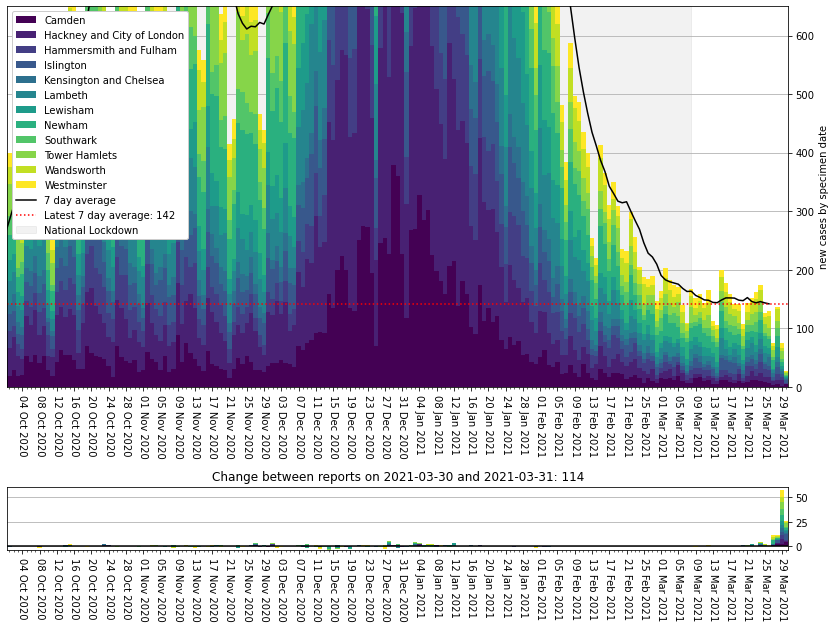

In [9]:
plot_areas(for_date, areas=london_areas, ylim=650)

In [10]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [11]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
S12000005,Clackmannanshire,199.844781,103.0,2021-03-30
E07000150,Corby,167.548257,121.0,2021-03-30
E08000018,Rotherham,126.219335,335.0,2021-03-30
N09000009,Mid Ulster,123.882366,184.0,2021-03-30
E08000017,Doncaster,119.272821,372.0,2021-03-30
E07000218,North Warwickshire,116.450110,76.0,2021-03-30
E08000036,Wakefield,113.691173,396.0,2021-03-30
S12000050,North Lanarkshire,113.073791,386.0,2021-03-30
S12000040,West Lothian,113.052977,207.0,2021-03-30


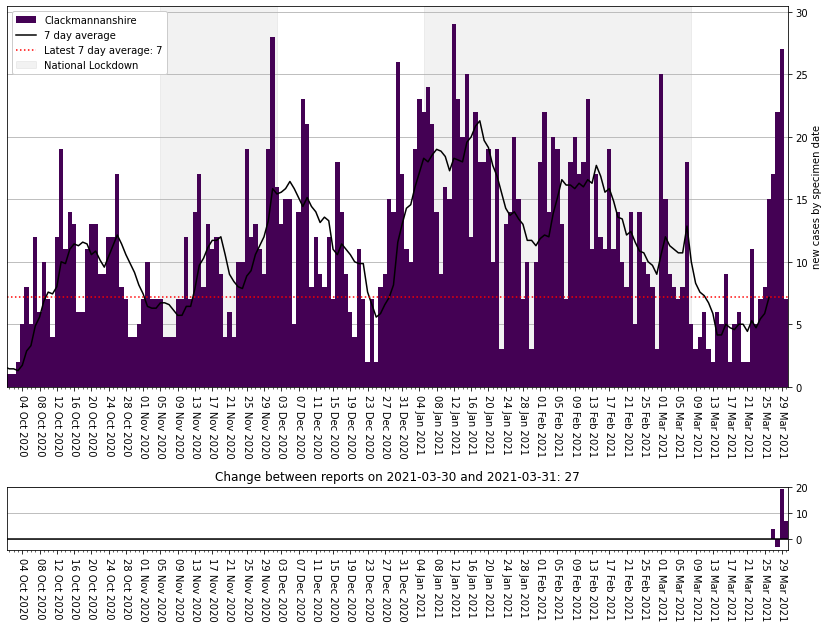

In [12]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [13]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000035,Leeds,93.804491,744.0,2021-03-30
E08000025,Birmingham,54.124307,618.0,2021-03-30
E08000032,Bradford,103.746739,560.0,2021-03-30
E08000019,Sheffield,92.843843,543.0,2021-03-30
S12000049,Glasgow City,71.550417,453.0,2021-03-30
E08000003,Manchester,76.692388,424.0,2021-03-30
E08000036,Wakefield,113.691173,396.0,2021-03-30
S12000050,North Lanarkshire,113.073791,386.0,2021-03-30
E08000017,Doncaster,119.272821,372.0,2021-03-30


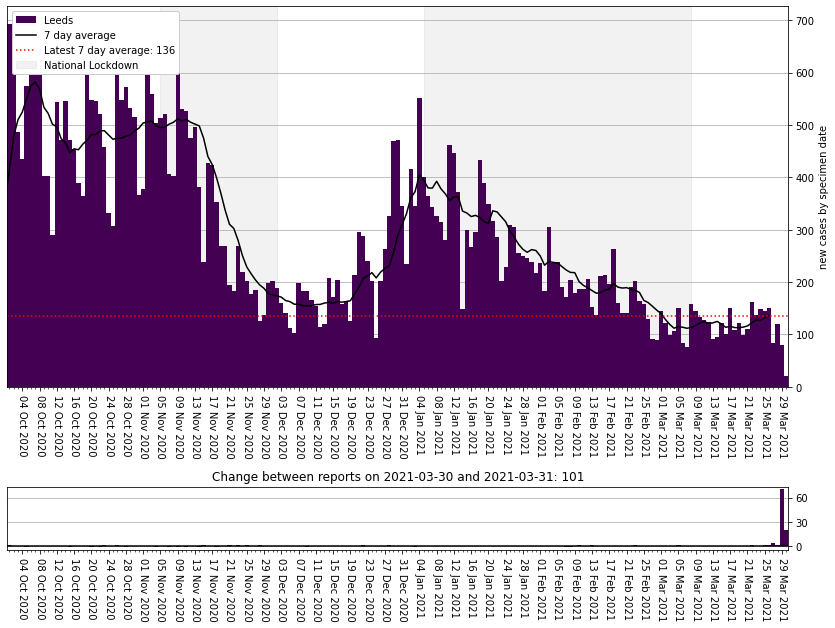

In [14]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [15]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 1.0
phe_max = 0.25

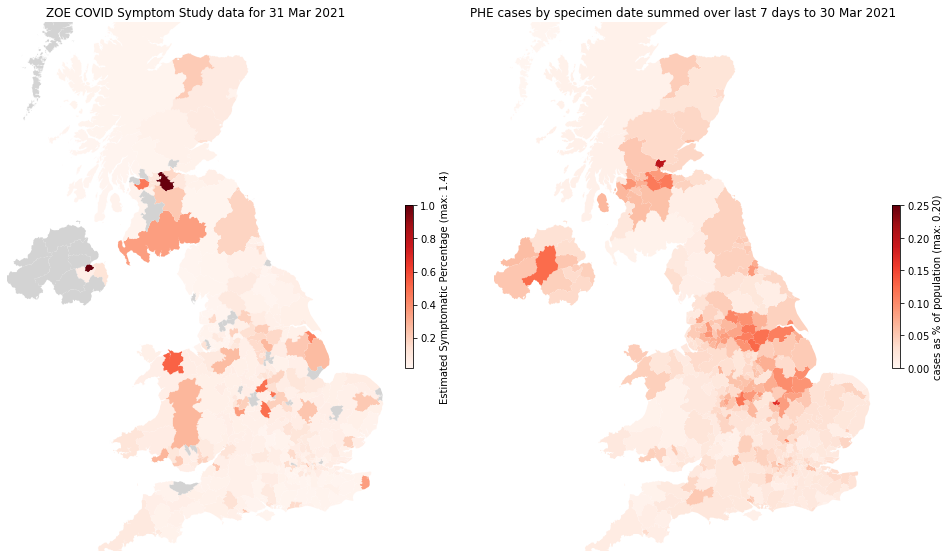

In [16]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [17]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...